<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Seasonal-arima-forecasting lab

---


### Lab Guide

- [Load the European retail data](#load-the-european-retail-data)
- [Decompose the timeseries and plot](#decompose-the-timeseries-and-plot)
- [Perform differencing and seasonal differencing of the time series.](#take-a-second-order-difference-of-the-retail-timeseries)
- [Dickey-Fuller test of stationarity](#dickey-fuller-test-of-stationarity)
- [Seasonal ARIMA model (SARIMAX)](#seasonal-arima-with-additional-predictors-sarimax)
- [Forecast using the SARIMAX model](#forecast-using-the-sarimax-model)

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<a id="statsmodels-timeseries-tools"></a>
## Statsmodels timeseries tools
---


In [2]:
# this will filter out a lot of future warnings from statsmodels
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

<a id="load-the-european-retail-data"></a>
## Load the European retail data
---

Create an index representing each quartal.

In [3]:
df = pd.read_csv('../../../../resource-datasets/european_retail_trade/euretail.csv')
df = df.set_index(['Year'])
df.head()

,Qtr1,Qtr2,Qtr3,Qtr4
Year,,,,
1996,89.13,89.52,89.88,90.12
1997,89.19,89.78,90.03,90.38
1998,90.27,90.77,91.85,92.51
1999,92.21,92.52,93.62,94.15
2000,94.69,95.34,96.04,96.30


In [4]:
df_stacked = df.stack()
df_stacked.head()

Year         
1996     Qtr1    89.13
         Qtr2    89.52
         Qtr3    89.88
         Qtr4    90.12
1997     Qtr1    89.19
dtype: float64

In [67]:
df_stacked.reset_index().head()

,Year,level_1,0
0,1996,Qtr1,89.13
1,1996,Qtr2,89.52
2,1996,Qtr3,89.88
3,1996,Qtr4,90.12
4,1997,Qtr1,89.19


<a id="decompose-the-timeseries-and-plot"></a>
## Decompose the timeseries and plot
---

Which frequency would you choose for the seasonality?

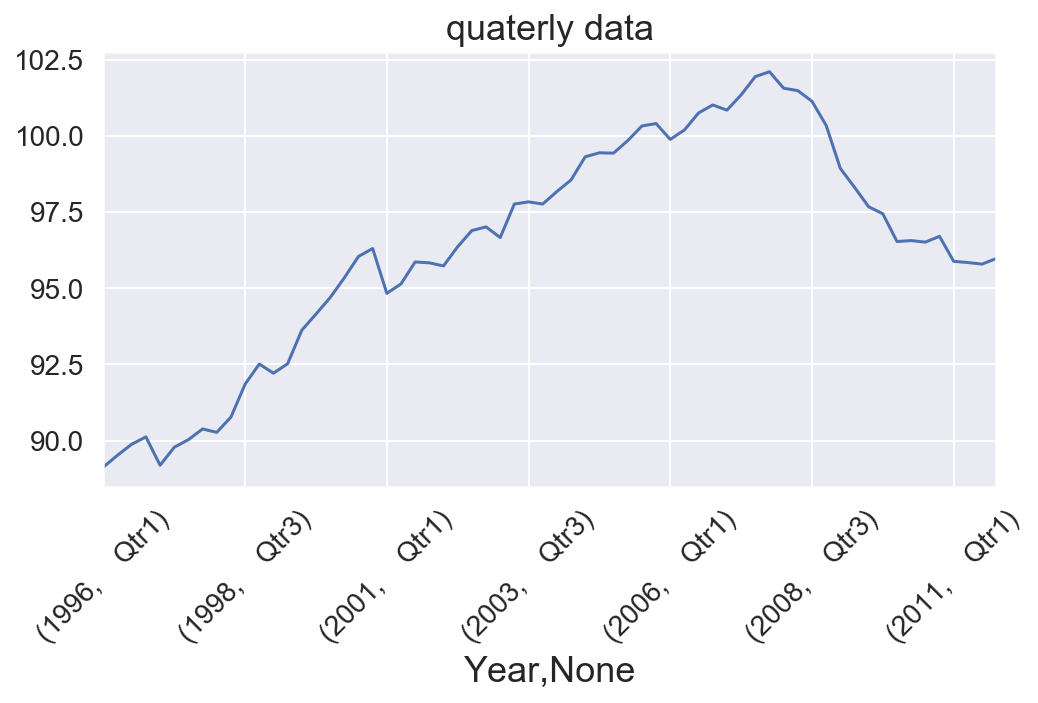

In [6]:
df_stacked.plot(
    figsize=(8, 4), title='quaterly data', fontsize=14, rot=45)
plt.show()


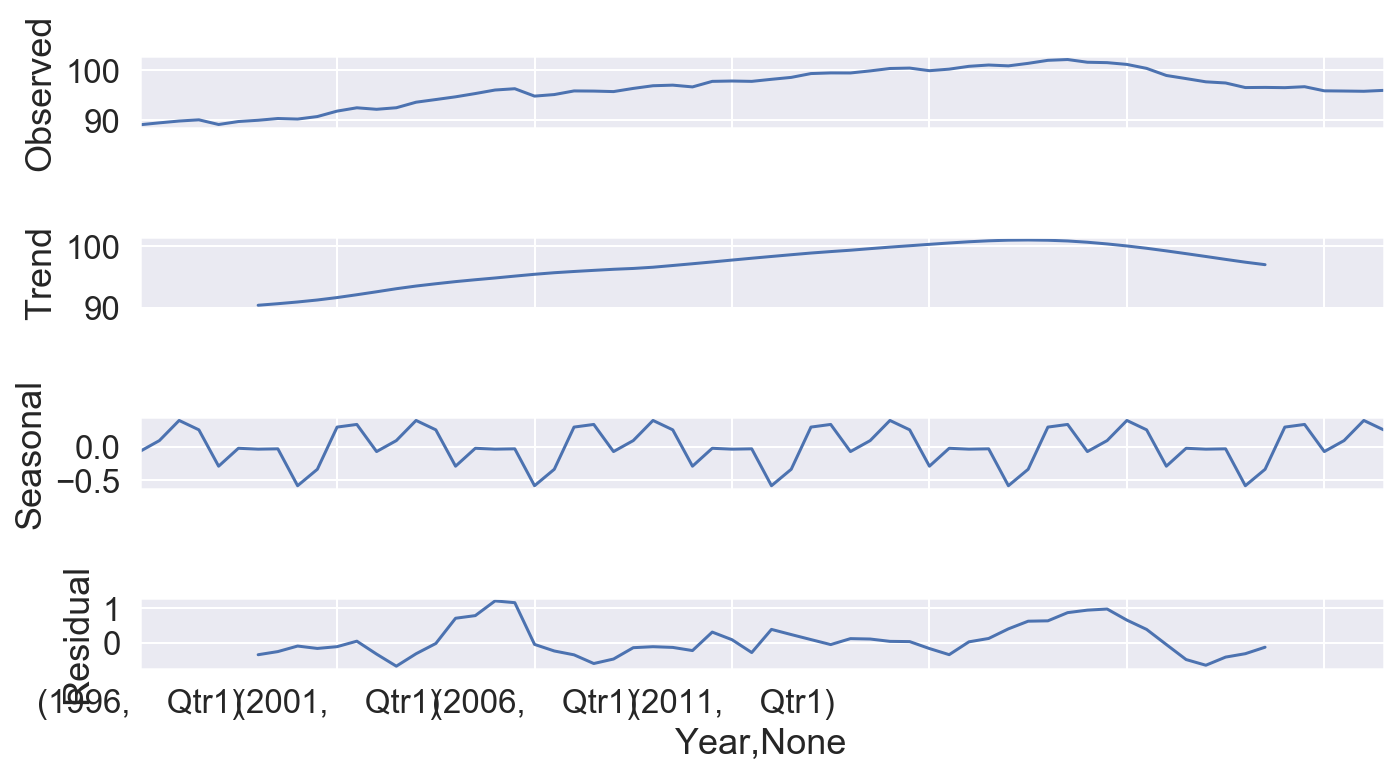

In [7]:
decomposition = seasonal_decompose(df_stacked, freq=12)
fig = decomposition.plot()
fig.set_size_inches(12, 6)
plt.show()


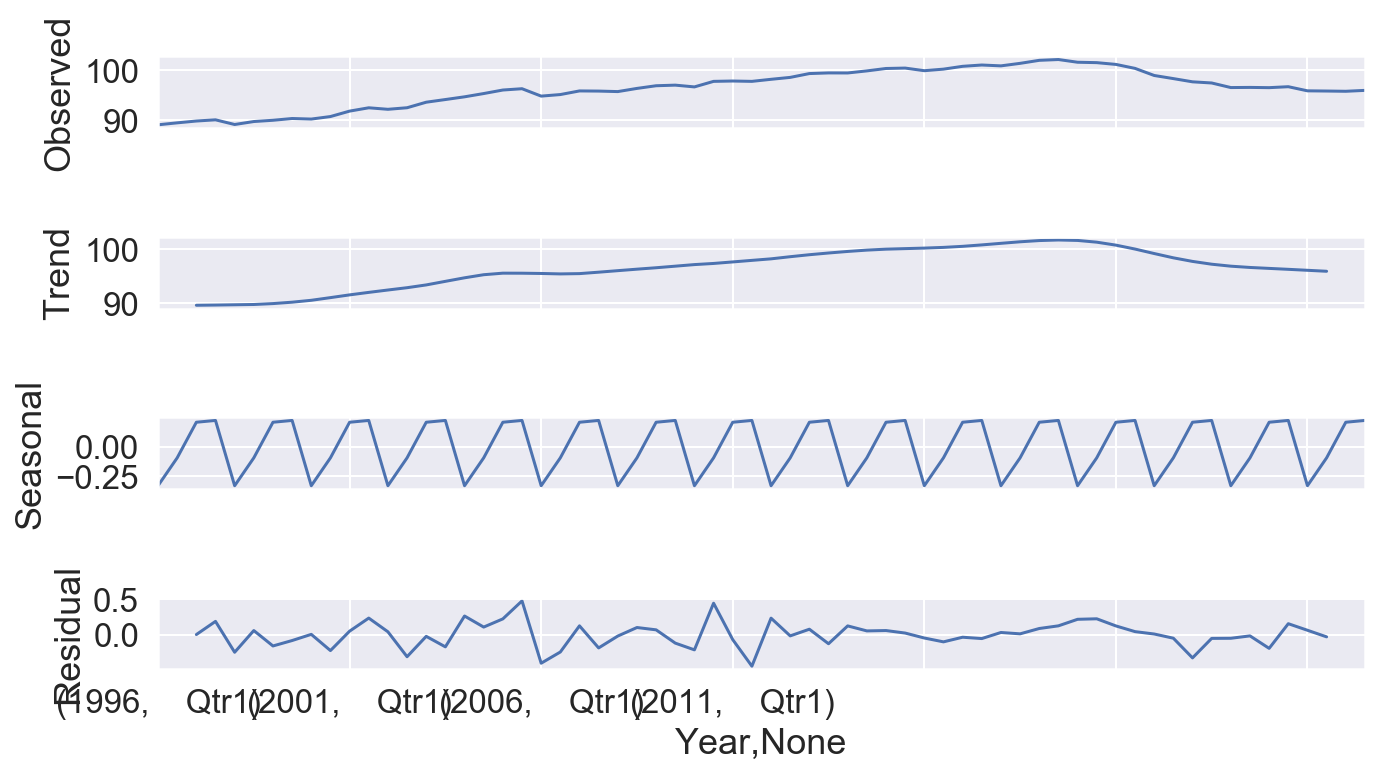

In [8]:
decomposition = seasonal_decompose(df_stacked, freq=4)
fig = decomposition.plot()
fig.set_size_inches(12, 6)
plt.show()

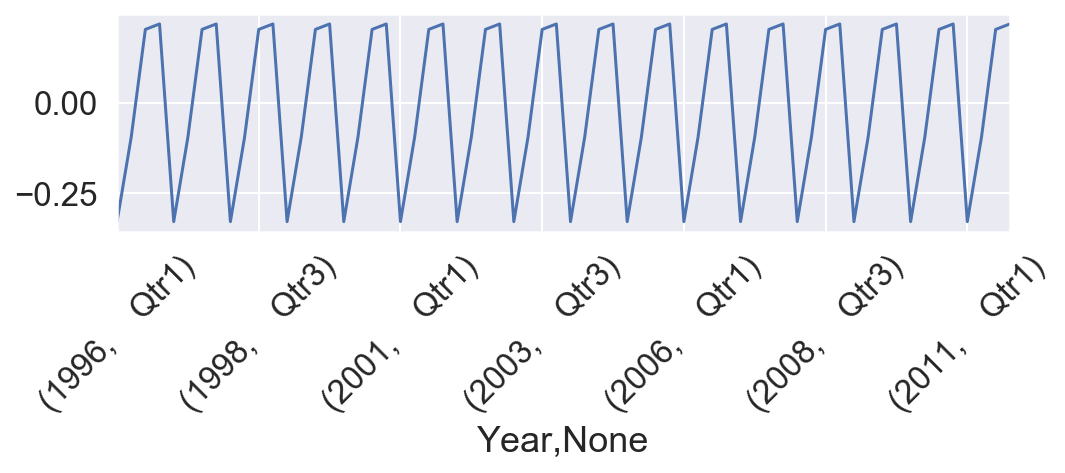

In [9]:
decomposition.seasonal.plot(figsize=(8, 2), rot=45)
plt.show()


<a id="take-a-second-order-difference-of-the-retail-timeseries"></a>
## Perform differencing and seasonal differencing of the time series.

Plot the ACF and PACF for various combinations of differencing steps.

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

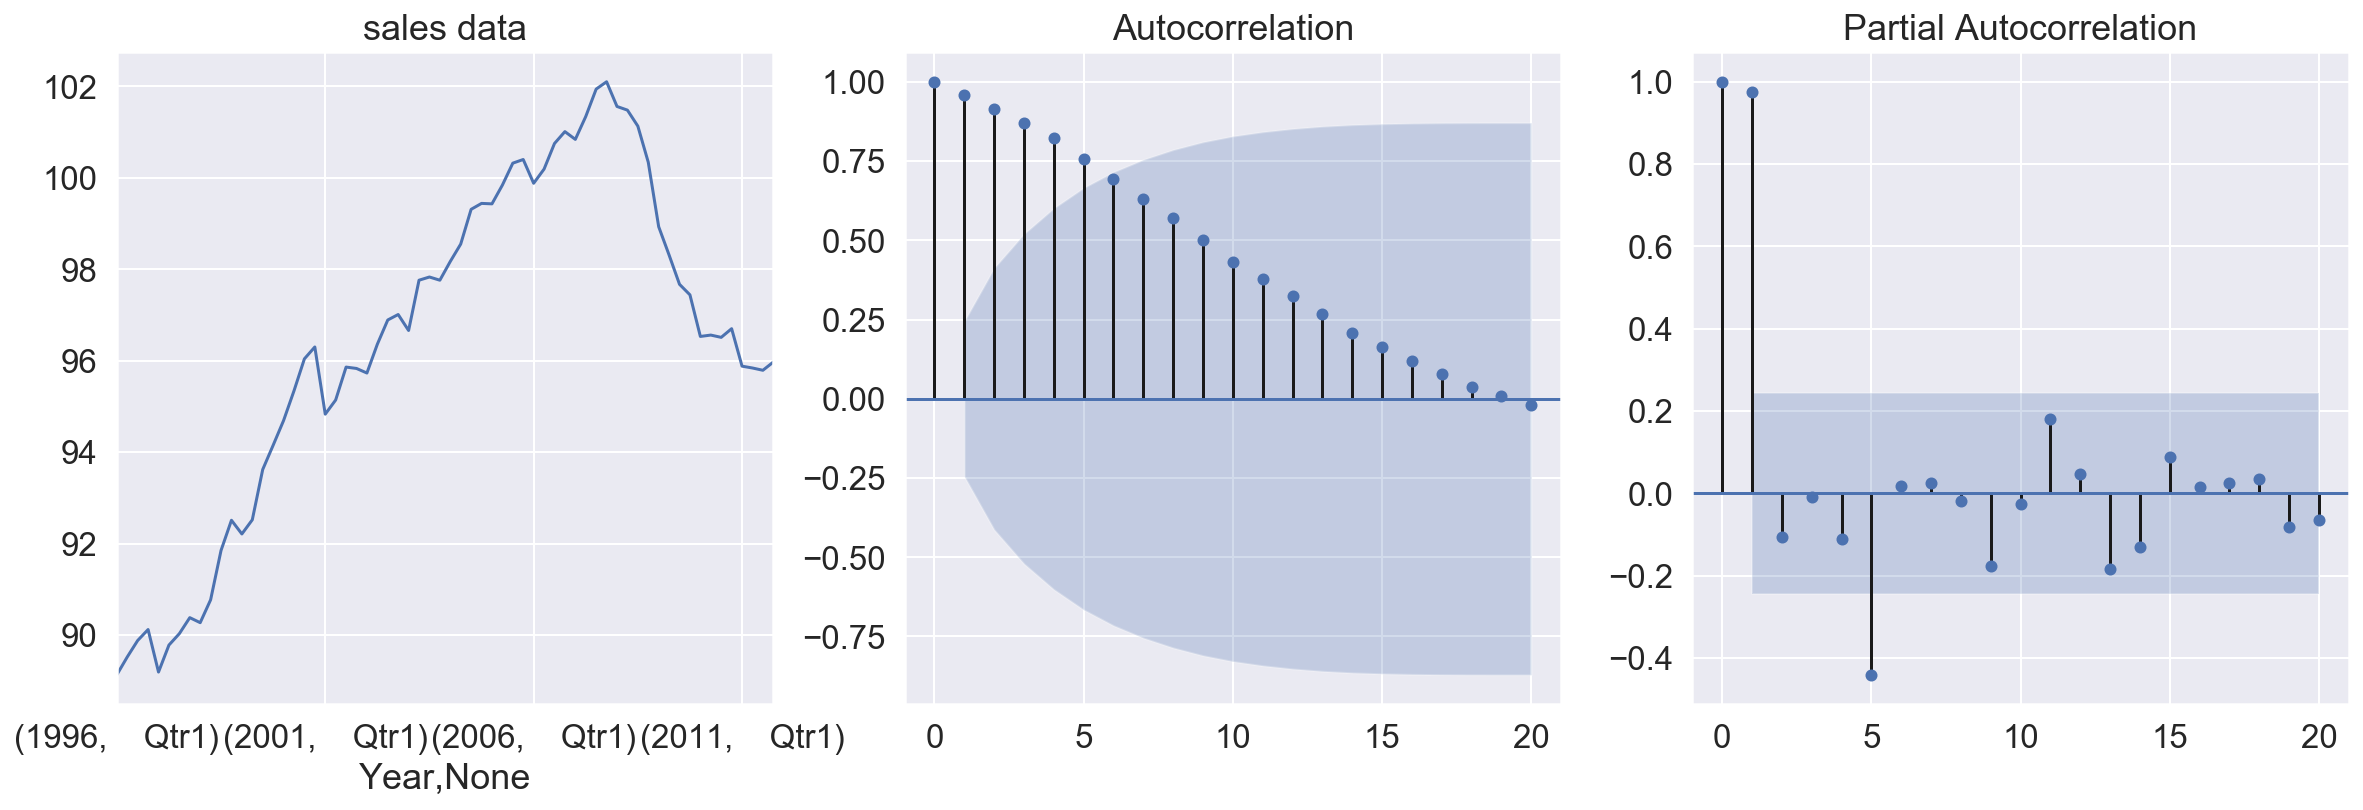

In [11]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 6))
df_stacked.plot(ax=ax[0], title='sales data')
plot_acf(df_stacked, lags=20, alpha=0.05, ax=ax[1])
plot_pacf(df_stacked, lags=20, alpha=0.05, ax=ax[2])
plt.show()


In [12]:
df_diff = df_stacked.diff()[1:]

In [13]:
df_diff2 = df_stacked.diff().diff()[2:]

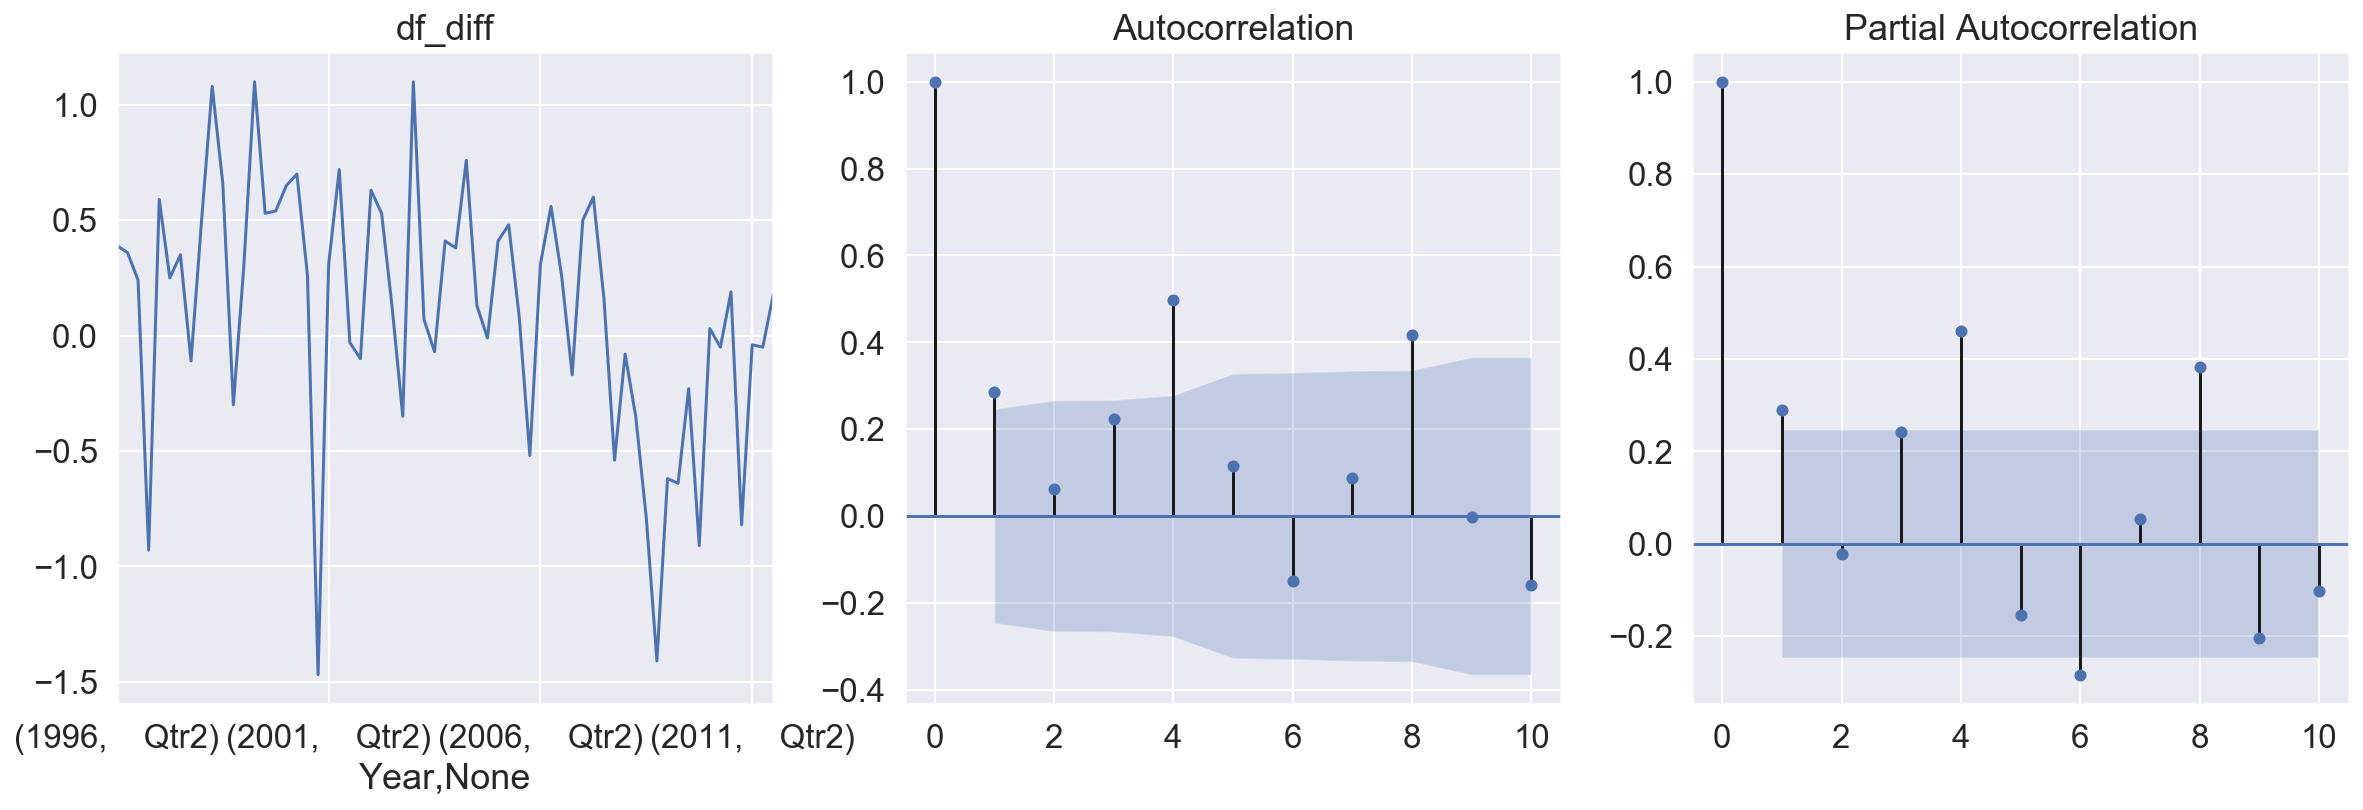

In [14]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 6))
df_diff.plot(ax=ax[0], title='df_diff')
plot_acf(df_diff, lags=10, alpha=0.05, ax=ax[1])
plot_pacf(df_diff, lags=10, alpha=0.05, ax=ax[2])
plt.show()


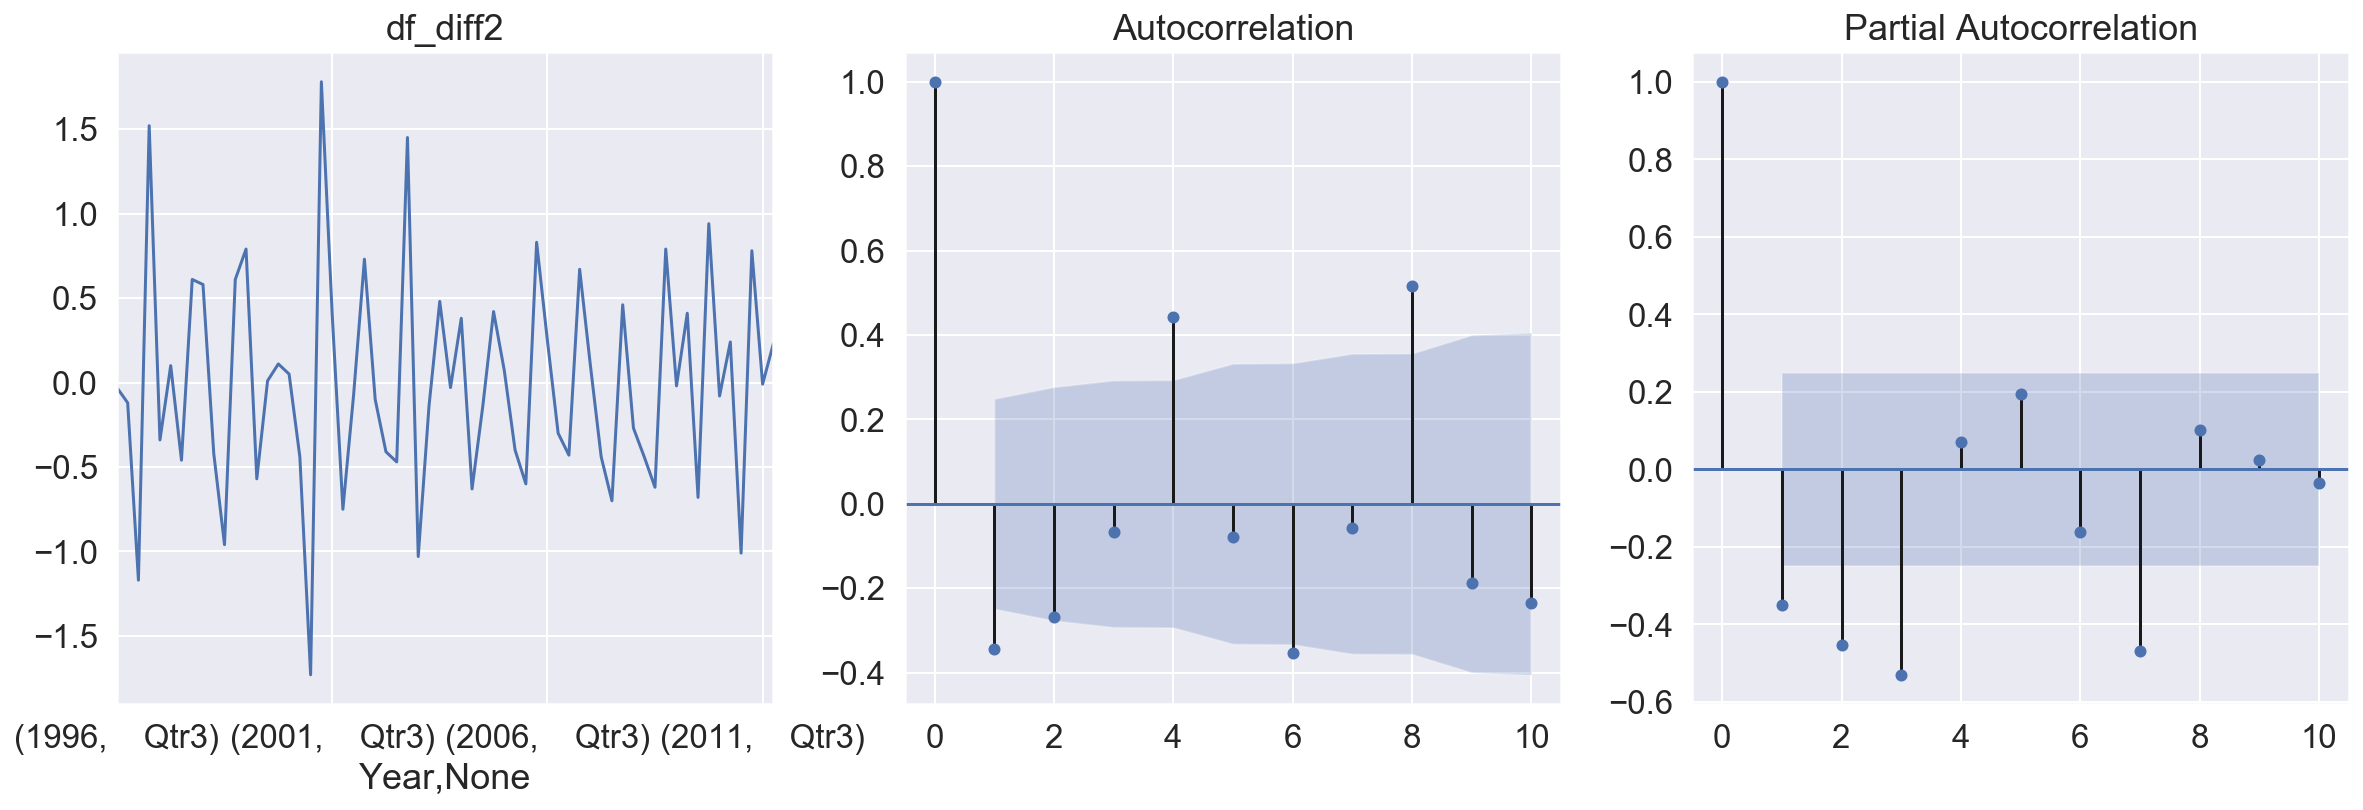

In [15]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 6))
df_diff2.plot(ax=ax[0], title='df_diff2')
plot_acf(df_diff2, lags=10, alpha=0.05, ax=ax[1])
plot_pacf(df_diff2, lags=10, alpha=0.05, ax=ax[2])
plt.show()


In [16]:
#seasonal difference, d=0, d_S=1
df_seasonal = df_stacked - df_stacked.shift(4)


In [17]:
df_seasonal_diff = df_stacked.diff() - df_stacked.diff().shift(4)

In [18]:
df_seasonal_diff2 = (df_stacked-df_stacked.shift(4)).diff().diff()

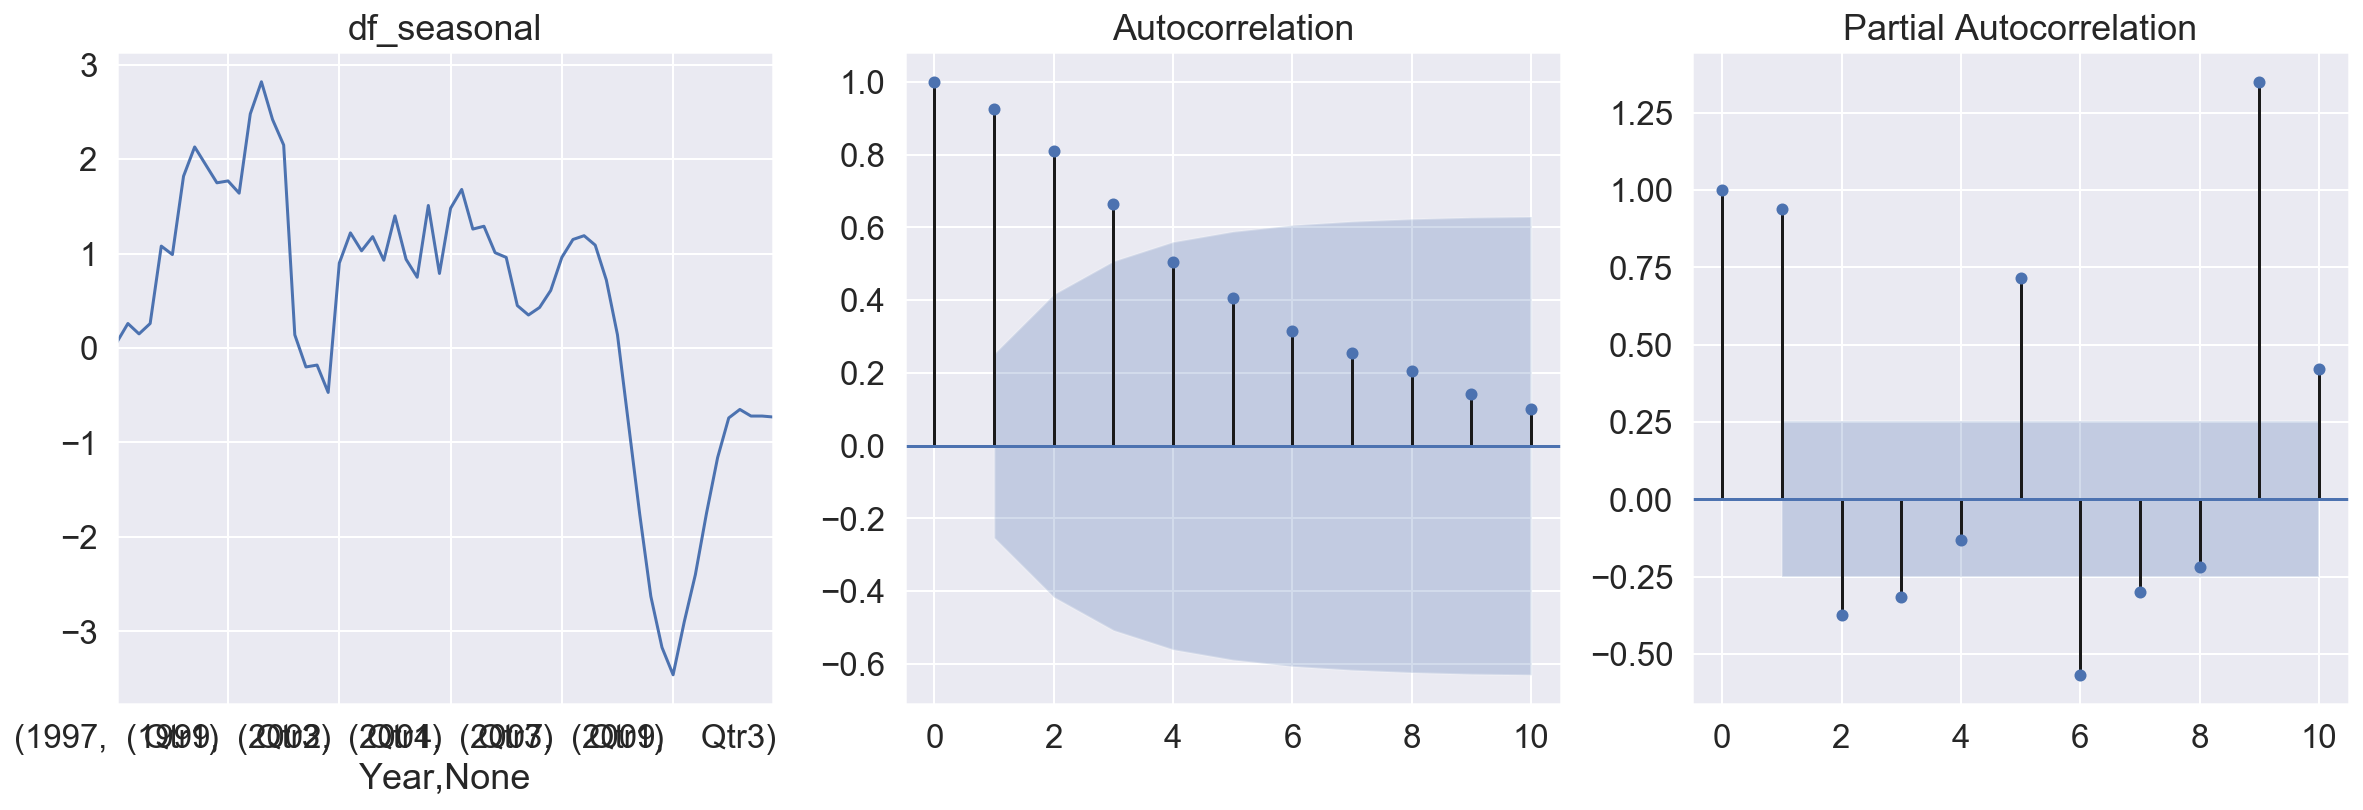

In [24]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 6))
df_seasonal[4:].plot(ax=ax[0], title='df_seasonal')
plot_acf(df_seasonal[4:], lags=10, alpha=0.05, ax=ax[1])
plot_pacf(df_seasonal[4:], lags=10, alpha=0.05, ax=ax[2])
plt.show()

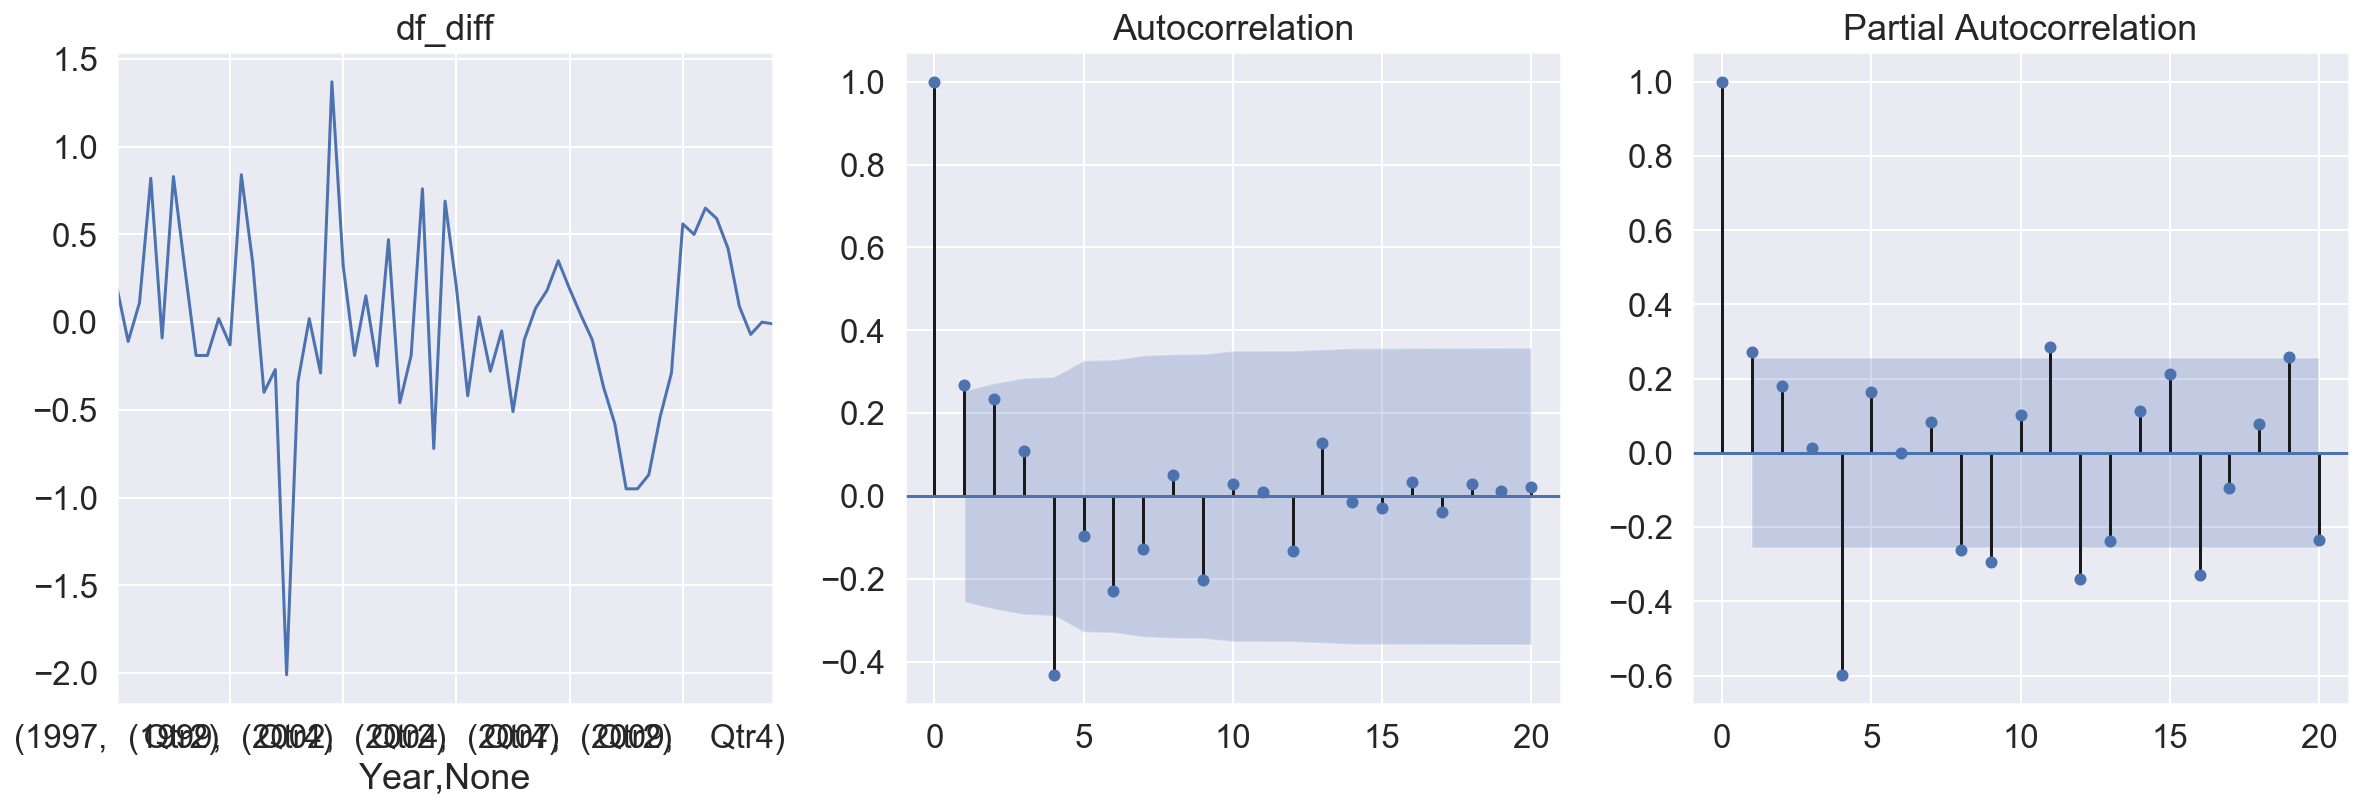

In [23]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 6))
df_seasonal_diff[5:].plot(ax=ax[0], title='df_diff')
plot_acf(df_seasonal_diff[5:], lags=20, alpha=0.05, ax=ax[1])
plot_pacf(df_seasonal_diff[5:], lags=20, alpha=0.05, ax=ax[2])
plt.show()

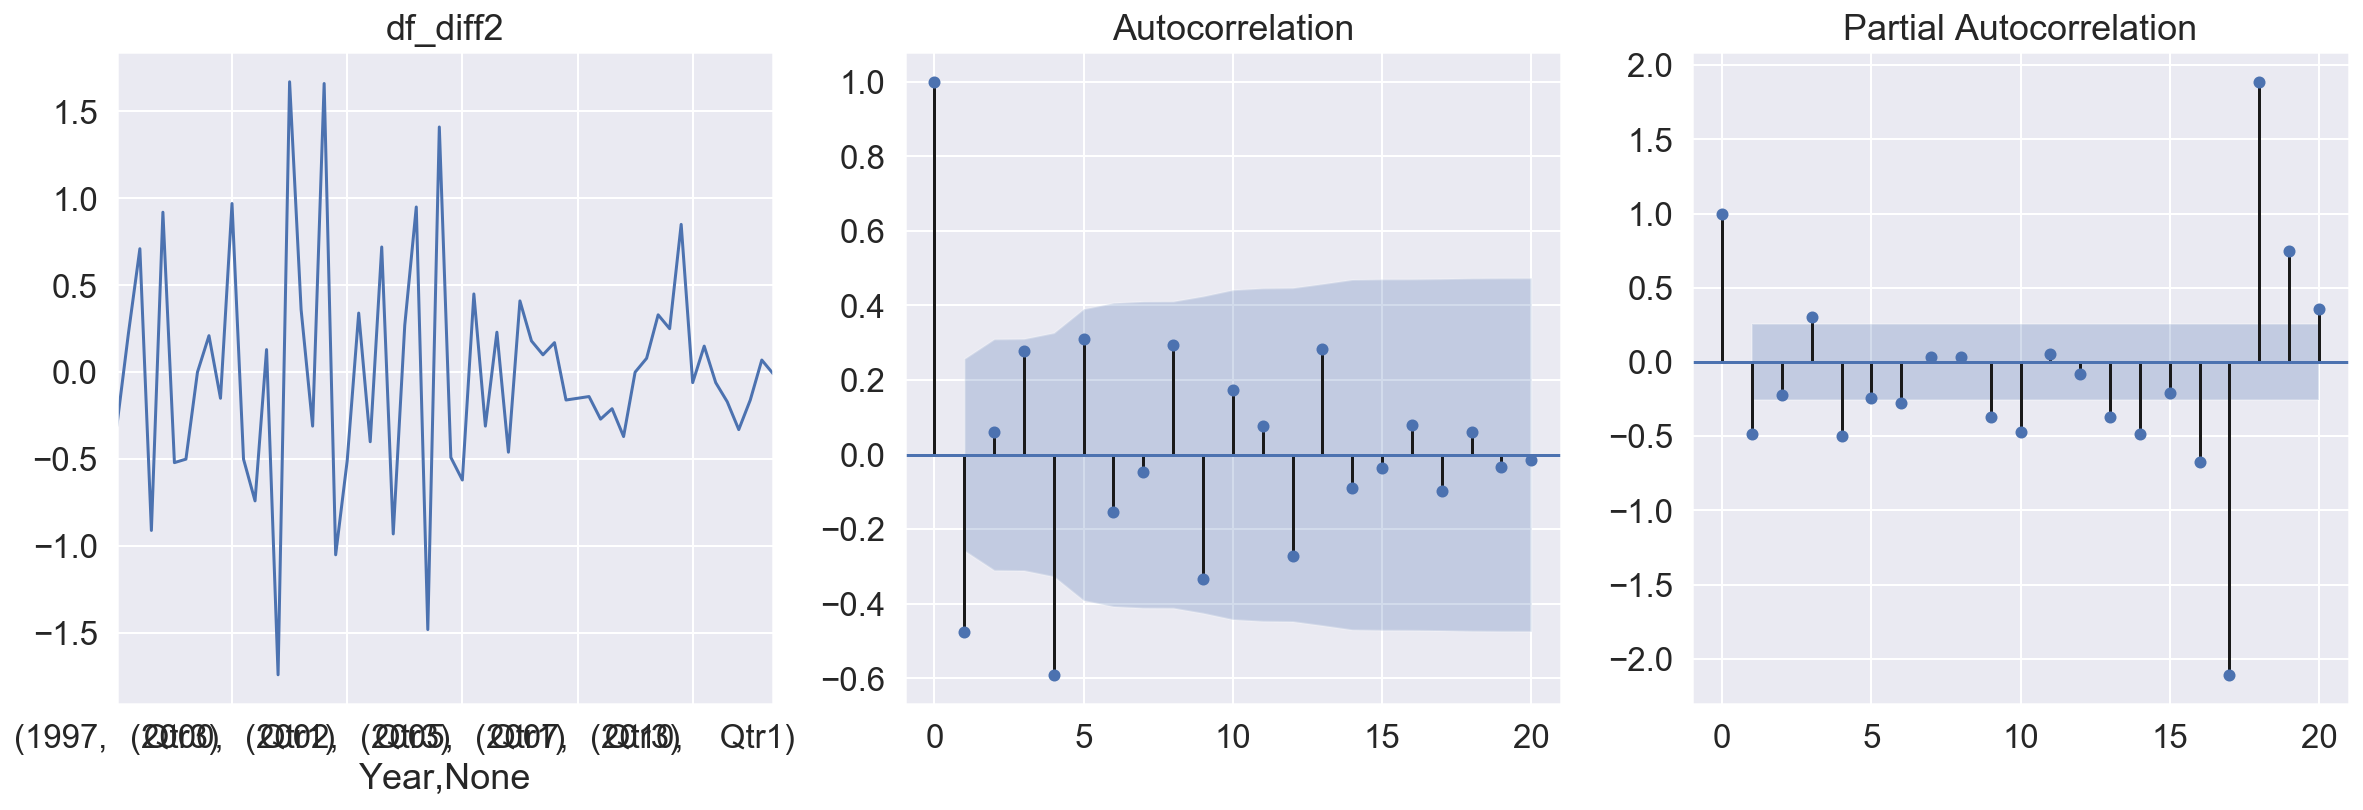

In [21]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 6))
df_seasonal_diff2[6:].plot(ax=ax[0], title='df_diff2')
plot_acf(df_seasonal_diff2[6:], lags=20, alpha=0.05, ax=ax[1])
plot_pacf(df_seasonal_diff2[6:], lags=20, alpha=0.05, ax=ax[2])
plt.show()

In [40]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [41]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 8) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_stacked,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
 
            results = mod.fit()
 
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [44]:
pdq = list(itertools.product(p, d, q))

In [72]:
seasonal_pdq = [(x[0], x[1], x[2], 8) for x in list(itertools.product(p, d, q))]

In [73]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 8)
SARIMAX: (0, 0, 1) x (0, 1, 0, 8)
SARIMAX: (0, 1, 0) x (0, 1, 1, 8)
SARIMAX: (0, 1, 0) x (1, 0, 0, 8)


In [74]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_stacked,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
 
            results = mod.fit()
 
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was pro

ARIMA(0, 0, 0)x(0, 0, 0, 8)12 - AIC:756.5849402050983
ARIMA(0, 0, 0)x(0, 0, 1, 8)12 - AIC:610.7110809416047
ARIMA(0, 0, 0)x(0, 1, 0, 8)12 - AIC:267.293519562612
ARIMA(0, 0, 0)x(0, 1, 1, 8)12 - AIC:219.09999422728154
ARIMA(0, 0, 0)x(1, 0, 0, 8)12 - AIC:267.29193295655887
ARIMA(0, 0, 0)x(1, 0, 1, 8)12 - AIC:259.41702401916984
ARIMA(0, 0, 0)x(1, 1, 0, 8)12 - AIC:223.3689057915024


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be

ARIMA(0, 0, 0)x(1, 1, 1, 8)12 - AIC:219.2856329685369
ARIMA(0, 0, 1)x(0, 0, 0, 8)12 - AIC:665.8658083363142
ARIMA(0, 0, 1)x(0, 0, 1, 8)12 - AIC:531.037572368702
ARIMA(0, 0, 1)x(0, 1, 0, 8)12 - AIC:197.75501013629076
ARIMA(0, 0, 1)x(0, 1, 1, 8)12 - AIC:157.13381877346941
ARIMA(0, 0, 1)x(1, 0, 0, 8)12 - AIC:200.76833908429302


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be

ARIMA(0, 0, 1)x(1, 0, 1, 8)12 - AIC:261.59855146724874
ARIMA(0, 0, 1)x(1, 1, 0, 8)12 - AIC:169.91299245046903
ARIMA(0, 0, 1)x(1, 1, 1, 8)12 - AIC:159.2094166425589
ARIMA(0, 1, 0)x(0, 0, 0, 8)12 - AIC:105.91009998618762
ARIMA(0, 1, 0)x(0, 0, 1, 8)12 - AIC:88.12319706674266
ARIMA(0, 1, 0)x(0, 1, 0, 8)12 - AIC:97.00846018140054
ARIMA(0, 1, 0)x(0, 1, 1, 8)12 - AIC:70.84219922114626
ARIMA(0, 1, 0)x(1, 0, 0, 8)12 - AIC:83.20077976005453
ARIMA(0, 1, 0)x(1, 0, 1, 8)12 - AIC:76.76875699140643
ARIMA(0, 1, 0)x(1, 1, 0, 8)12 - AIC:73.72296878587169
ARIMA(0, 1, 0)x(1, 1, 1, 8)12 - AIC:74.99207776620788
ARIMA(0, 1, 1)x(0, 0, 0, 8)12 - AIC:100.88364545262918
ARIMA(0, 1, 1)x(0, 0, 1, 8)12 - AIC:76.817860045405
ARIMA(0, 1, 1)x(0, 1, 0, 8)12 - AIC:87.03930784078574
ARIMA(0, 1, 1)x(0, 1, 1, 8)12 - AIC:61.02826596241673
ARIMA(0, 1, 1)x(1, 0, 0, 8)12 - AIC:75.89831414780596
ARIMA(0, 1, 1)x(1, 0, 1, 8)12 - AIC:67.12566300931766
ARIMA(0, 1, 1)x(1, 1, 0, 8)12 - AIC:66.54146474655309


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was pro

ARIMA(0, 1, 1)x(1, 1, 1, 8)12 - AIC:67.04783393894024
ARIMA(1, 0, 0)x(0, 0, 0, 8)12 - AIC:106.89597899062792
ARIMA(1, 0, 0)x(0, 0, 1, 8)12 - AIC:89.98034808548695
ARIMA(1, 0, 0)x(0, 1, 0, 8)12 - AIC:99.21757391209303


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be

ARIMA(1, 0, 0)x(0, 1, 1, 8)12 - AIC:86.8875506704509
ARIMA(1, 0, 0)x(1, 0, 0, 8)12 - AIC:85.03382526276933
ARIMA(1, 0, 0)x(1, 0, 1, 8)12 - AIC:87.86290779357223
ARIMA(1, 0, 0)x(1, 1, 0, 8)12 - AIC:74.76834293410008
ARIMA(1, 0, 0)x(1, 1, 1, 8)12 - AIC:76.97172238129218
ARIMA(1, 0, 1)x(0, 0, 0, 8)12 - AIC:102.67761163343668


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 8)12 - AIC:82.36827960736255
ARIMA(1, 0, 1)x(0, 1, 0, 8)12 - AIC:90.32577740676226
ARIMA(1, 0, 1)x(0, 1, 1, 8)12 - AIC:76.54655479180364
ARIMA(1, 0, 1)x(1, 0, 0, 8)12 - AIC:77.81166070423721


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be

ARIMA(1, 0, 1)x(1, 0, 1, 8)12 - AIC:80.20777627030287
ARIMA(1, 0, 1)x(1, 1, 0, 8)12 - AIC:67.4411566980325


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was pro

ARIMA(1, 0, 1)x(1, 1, 1, 8)12 - AIC:68.78112357091888
ARIMA(1, 1, 0)x(0, 0, 0, 8)12 - AIC:101.57445520610324
ARIMA(1, 1, 0)x(0, 0, 1, 8)12 - AIC:78.51769283484676
ARIMA(1, 1, 0)x(0, 1, 0, 8)12 - AIC:83.75569155483242
ARIMA(1, 1, 0)x(0, 1, 1, 8)12 - AIC:55.67241811446745
ARIMA(1, 1, 0)x(1, 0, 0, 8)12 - AIC:71.13593198101067
ARIMA(1, 1, 0)x(1, 0, 1, 8)12 - AIC:62.61618927248029
ARIMA(1, 1, 0)x(1, 1, 0, 8)12 - AIC:62.22374512617379
ARIMA(1, 1, 0)x(1, 1, 1, 8)12 - AIC:63.06642625371973
ARIMA(1, 1, 1)x(0, 0, 0, 8)12 - AIC:102.75175340593279
ARIMA(1, 1, 1)x(0, 0, 1, 8)12 - AIC:76.08570956958394
ARIMA(1, 1, 1)x(0, 1, 0, 8)12 - AIC:81.0816219407654
ARIMA(1, 1, 1)x(0, 1, 1, 8)12 - AIC:54.44088097630662
ARIMA(1, 1, 1)x(1, 0, 0, 8)12 - AIC:70.2267414785164


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was pro

ARIMA(1, 1, 1)x(1, 0, 1, 8)12 - AIC:57.43565532491811
ARIMA(1, 1, 1)x(1, 1, 0, 8)12 - AIC:62.50977875212495
ARIMA(1, 1, 1)x(1, 1, 1, 8)12 - AIC:61.77031517975565


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [53]:
model = sm.tsa.statespace.SARIMAX(df_stacked,
                                  order=(1, 1, 1),
                                  seasonal_order=(1, 1, 1, 4)
                                  )
results = model.fit()
results.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   64
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                 -30.174
Date:                           Mon, 19 Aug 2019   AIC                             70.348
Time:                                   14:05:45   BIC                             80.736
Sample:                                        0   HQIC                            74.403
                                            - 64                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8838      0.170      5.191      0.000       0.550       1.217
ma.L1         -0.5207      0.217     -2.401      0.016      -0.946      -0.096
ar.S.L4       -0.0238      0.155     -0.154      0.878      -0.327       0.280
ma.S.L4       -0.9493      0.559     -1.697      0.090      -2.046       0.147
sigma2         0.1431      0.065      2.199      0.028       0.016       0.271
===================================================================================
Ljung-Box (Q):                       23.08   Jarque-Bera (JB):                 1.35
Prob(Q):                              0.99   Prob(JB):                         0.51
Heteroskedasticity (H):               0.60   Skew:                             0.08
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

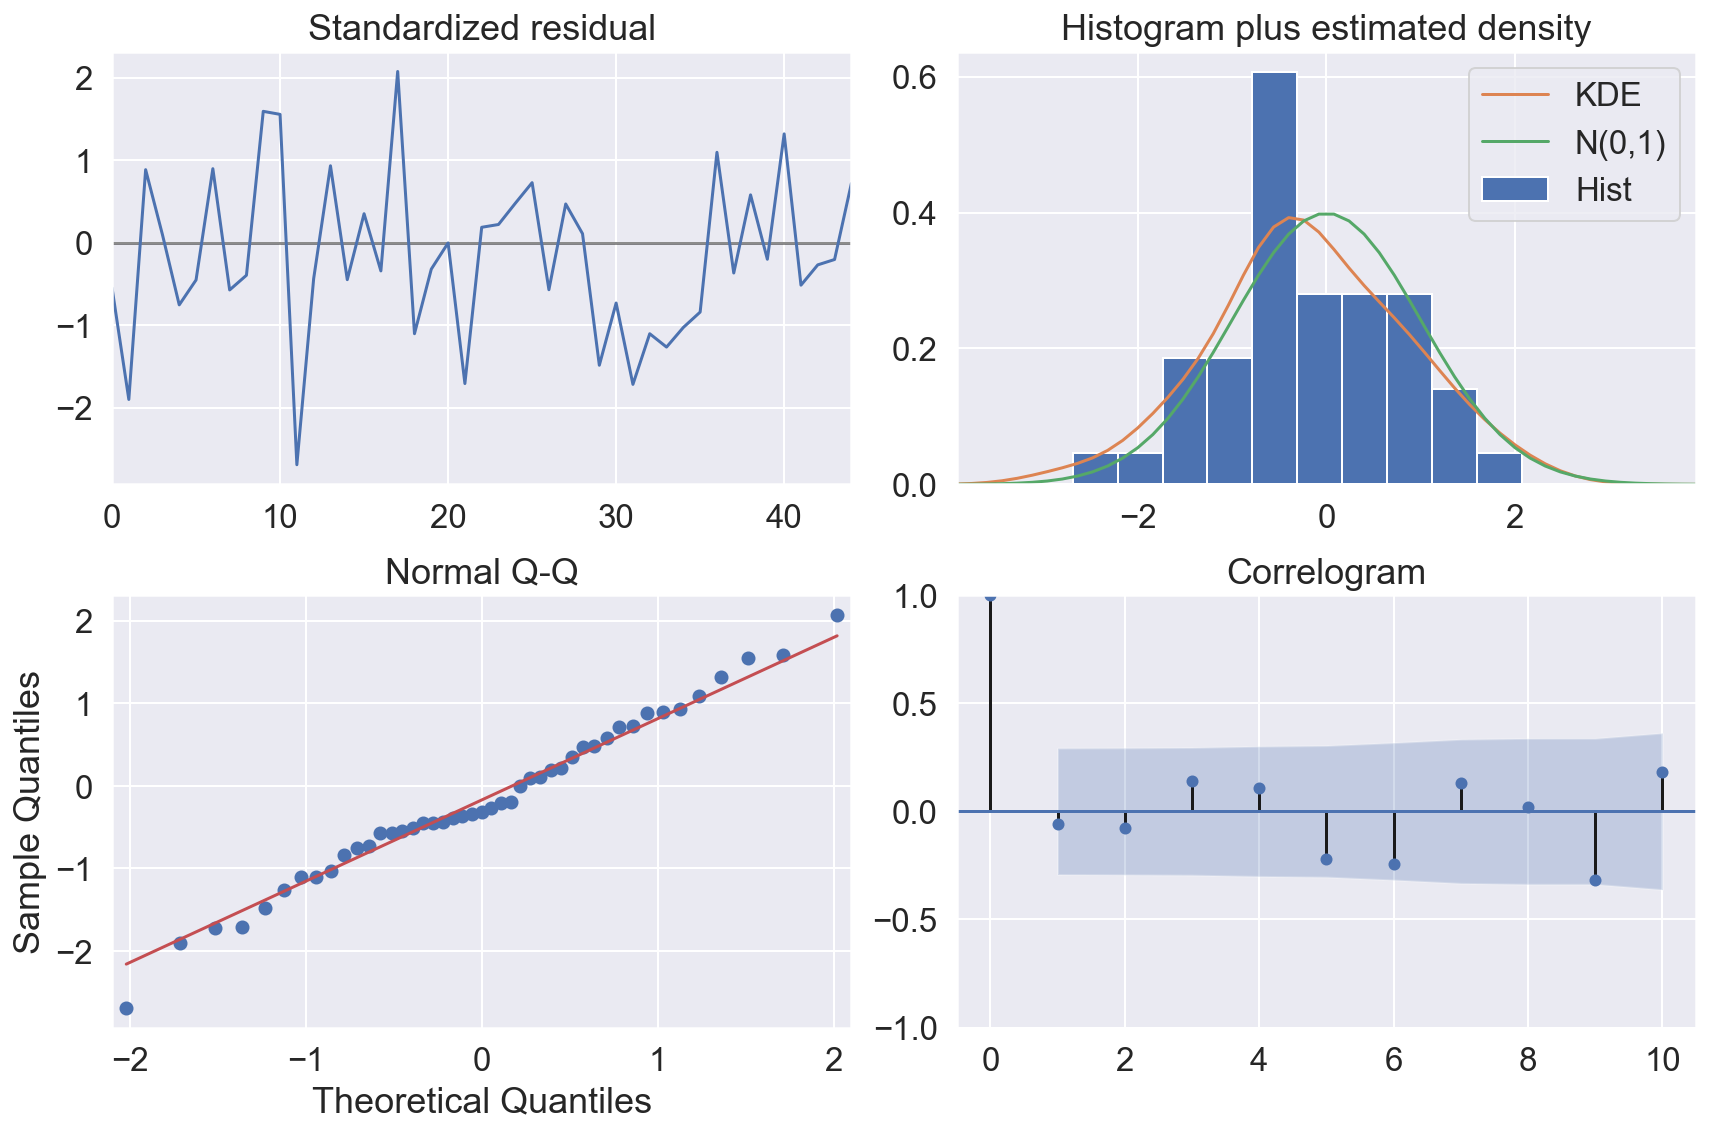

In [75]:
results.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


ValueError: setting an array element with a sequence.

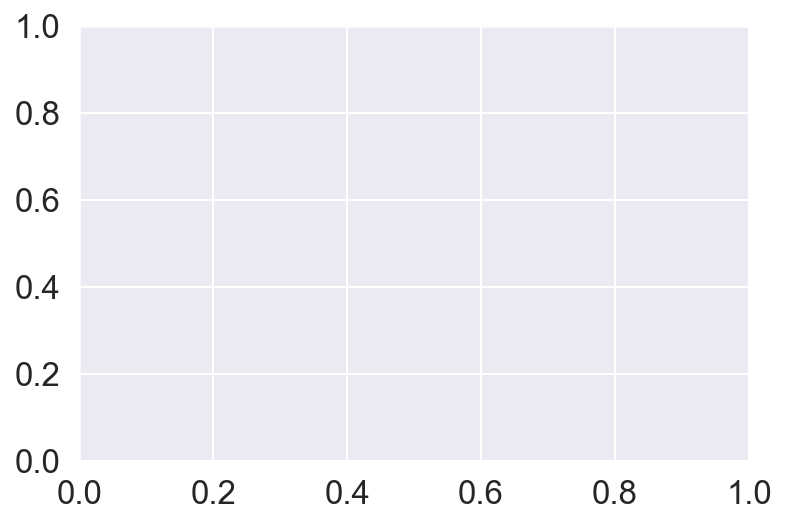

In [78]:
start_p = 20

# two equivalent ways for getting non-dynamical forecasts
# preds = results.forecast(50)
preds = results.predict(start=0, end=len(data)+20, dynamic=False)

preds_dyn = results.predict(start=len(data)-start_p,
                            end=len(data)+20, dynamic=True)
fcast = pd.concat([data, preds])
fcast_1 = pd.concat([data[:len(data)-start_p], preds_dyn])


plt.figure()
plt.plot(data, 'bo', preds, 'g--', preds_dyn, 'r-.')
plt.legend(['data', 'non-dynamical forecasting', 'dynamical forecasting'])
plt.show()

<a id="dickey-fuller-test-of-stationarity"></a>
## Dickey-Fuller test of stationarity
---

[Perform an (augmented) Dickey-Fuller test of stationarity](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) to evaluate whether or not the timeseries (or the differenced versions you created) are stationary.

In [22]:
from statsmodels.tsa.stattools import adfuller

In [61]:
def test_stationarity(timeseries, maxlag=15, regression='c', autolag='AIC'):
    '''Perform Dickey-Fuller test and print out results'''

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, maxlag=maxlag,
                      regression=regression, autolag=autolag)
    dfoutput = pd.Series(dftest[0:4], index=[
                         'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in list(dftest[4].items()):
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


def rolling(timeseries, window=12, center=True, figsize=(12, 8)):
    '''
    Plot original timeseries, 
    rolling mean over given window size and rolling 
    mean plus/minus standard deviation
    '''

    rolmean = timeseries.rolling(window=window, center=center).mean()
    rolstd = timeseries.rolling(window=window, center=center).std()

    # Plot rolling statistics:
    fig = plt.figure(figsize=figsize)
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std_plus = plt.plot(rolmean+rolstd, color='red', ls='--',
                        label='Rolling Mean +/- Rolling Std')
    std_minus = plt.plot(rolmean-rolstd, color='red', ls='--', label='')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

def autocorrelation_plot(y, lags=20, alpha=0.05):
    """
    Plot autocorrelations and partial autocorrelations
    Arguments:
    y: Time series
    lags: Number of lags to plot
    alpha: Confidence level for random noise
    """

    se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(y))

    fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

    plot_acf(y, lags=lags, alpha=alpha, ax=ax[0])
    ax[0].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)

    plot_pacf(y, lags=lags, alpha=alpha, ax=ax[1], method='ywmle')
    ax[1].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
    plt.show()

def test_and_vis(timeseries):
    '''
    Perform Dickey-Fuller test, 
    plot timeseries with rolling mean and autocorrelations
    '''
    test_stationarity(timeseries.dropna())
    #rolling(timeseries)
    autocorrelation_plot(timeseries.dropna())

In [62]:
df_stacked

Year         
1996     Qtr1     89.13
         Qtr2     89.52
         Qtr3     89.88
         Qtr4     90.12
1997     Qtr1     89.19
         Qtr2     89.78
         Qtr3     90.03
         Qtr4     90.38
1998     Qtr1     90.27
         Qtr2     90.77
         Qtr3     91.85
         Qtr4     92.51
1999     Qtr1     92.21
         Qtr2     92.52
         Qtr3     93.62
         Qtr4     94.15
2000     Qtr1     94.69
         Qtr2     95.34
         Qtr3     96.04
         Qtr4     96.30
2001     Qtr1     94.83
         Qtr2     95.14
         Qtr3     95.86
         Qtr4     95.83
2002     Qtr1     95.73
         Qtr2     96.36
         Qtr3     96.89
         Qtr4     97.01
2003     Qtr1     96.66
         Qtr2     97.76
                  ...  
2004     Qtr3     99.31
         Qtr4     99.44
2005     Qtr1     99.43
         Qtr2     99.84
         Qtr3    100.32
         Qtr4    100.40
2006     Qtr1     99.88
         Qtr2    100.19
         Qtr3    100.75
         Qtr4    101.01
20

In [63]:
test_and_vis(df_stacked)

Results of Dickey-Fuller Test:
Test Statistic                 -2.215585
p-value                         0.200638
#Lags Used                      9.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


NameError: name 'stats' is not defined

In [64]:
test_and_vis(df_seasonal)

Results of Dickey-Fuller Test:
Test Statistic                 -1.170875
p-value                         0.685998
#Lags Used                      4.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


NameError: name 'stats' is not defined

In [65]:
test_and_vis(df_seasonal_diff)

Results of Dickey-Fuller Test:
Test Statistic                 -3.409945
p-value                         0.010624
#Lags Used                      8.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64


NameError: name 'stats' is not defined

In [60]:
test_and_vis(df_seasonal_diff2)

Results of Dickey-Fuller Test:
Test Statistic                  0.000000
p-value                         0.958532
#Lags Used                     29.000000
Number of Observations Used    28.000000
Critical Value (1%)            -3.688926
Critical Value (5%)            -2.971989
Critical Value (10%)           -2.625296
dtype: float64


NameError: name 'stats' is not defined

<a id="seasonal-arima-with-additional-predictors-sarimax"></a>
## Seasonal ARIMA model (SARIMAX)
---

#### Fit a seasonal ARIMA model.

In [36]:
data = df_stacked
model = sm.tsa.statespace.SARIMAX(data,
                                  order=(1, 2, 1),
                                  seasonal_order=(1, 2, 1, 4))
results = model.fit(maxiter=10000)
results.summary()


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   64
Model:             SARIMAX(1, 2, 1)x(1, 2, 1, 4)   Log Likelihood                 -43.679
Date:                           Mon, 19 Aug 2019   AIC                             97.358
Time:                                   13:48:02   BIC                            107.303
Sample:                                        0   HQIC                           101.193
                                            - 64                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2114      0.316     -0.668      0.504      -0.831       0.409
ma.L1         -0.3148      0.271     -1.162      0.245      -0.846       0.216
ar.S.L4       -0.5428      0.107     -5.069      0.000      -0.753      -0.333
ma.S.L4       -0.9949      7.256     -0.137      0.891     -15.217      13.227
sigma2         0.2220      1.585      0.140      0.889      -2.884       3.328
===================================================================================
Ljung-Box (Q):                       30.35   Jarque-Bera (JB):                 3.33
Prob(Q):                              0.87   Prob(JB):                         0.19
Heteroskedasticity (H):               0.45   Skew:                            -0.57
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

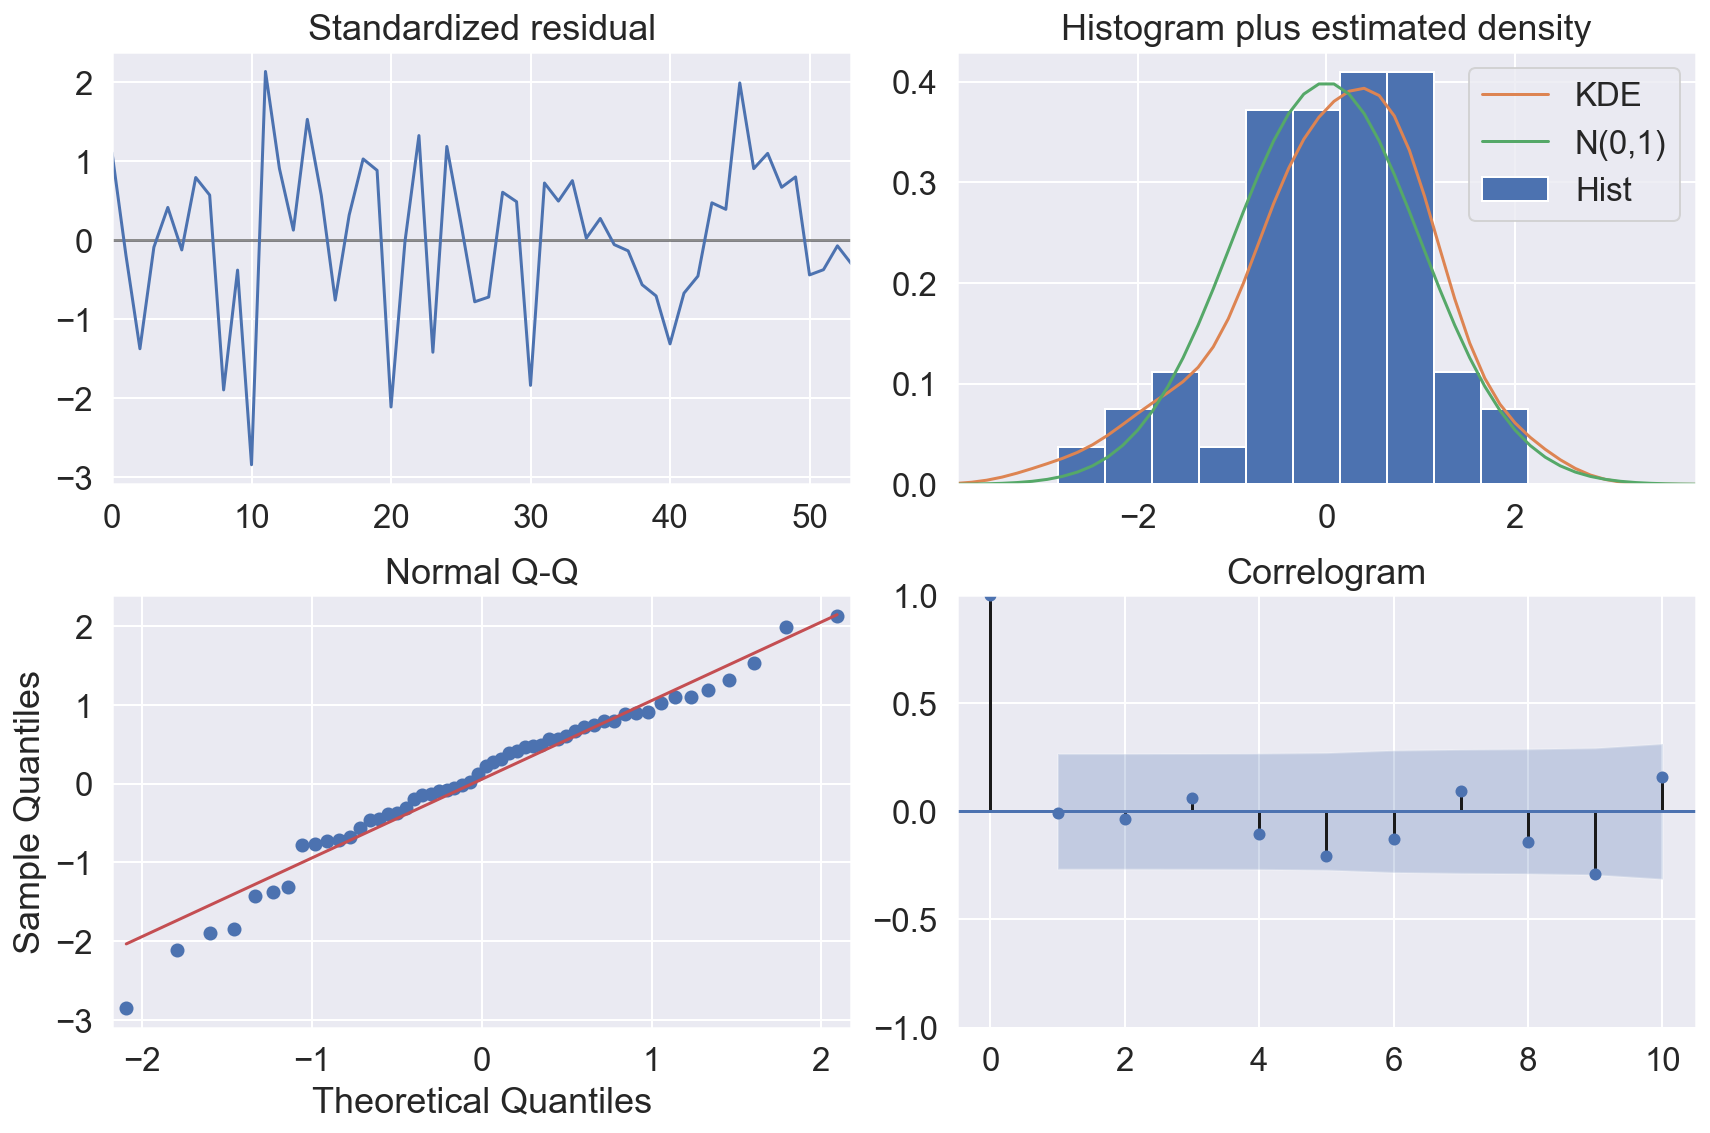

In [37]:
results.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


ValueError: setting an array element with a sequence.

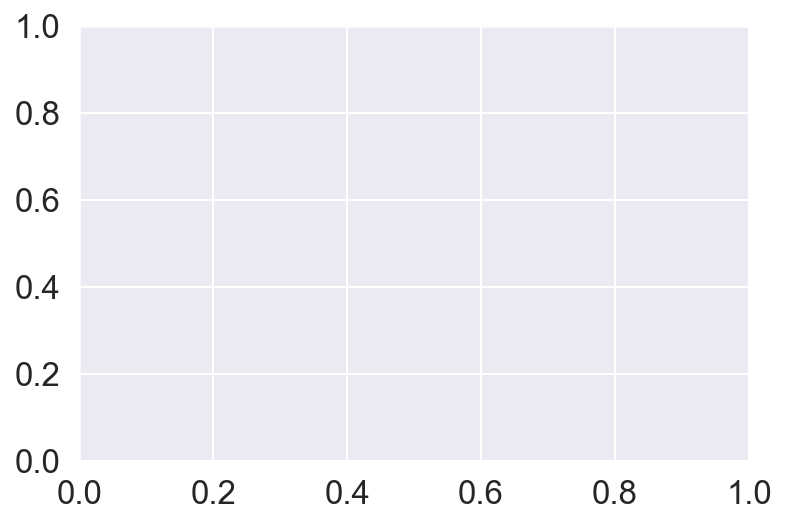

In [34]:
start_p = 50
preds = results.predict(start=0, end=len(data)+50, dynamic=False)
preds_dyn = results.predict(start=len(data)-start_p,
                            end=len(data)+50, dynamic=True)
fcast = pd.concat([data, preds])
fcast_1 = pd.concat([data[:len(data)-start_p], preds_dyn])

plt.figure()
plt.plot(data, 'bo', preds, 'g--', preds_dyn, 'r-.')
plt.legend(['data', 'non-dynamical forecasting', 'dynamical forecasting'])
plt.show()


NameError: name 'mean_squared_error' is not defined

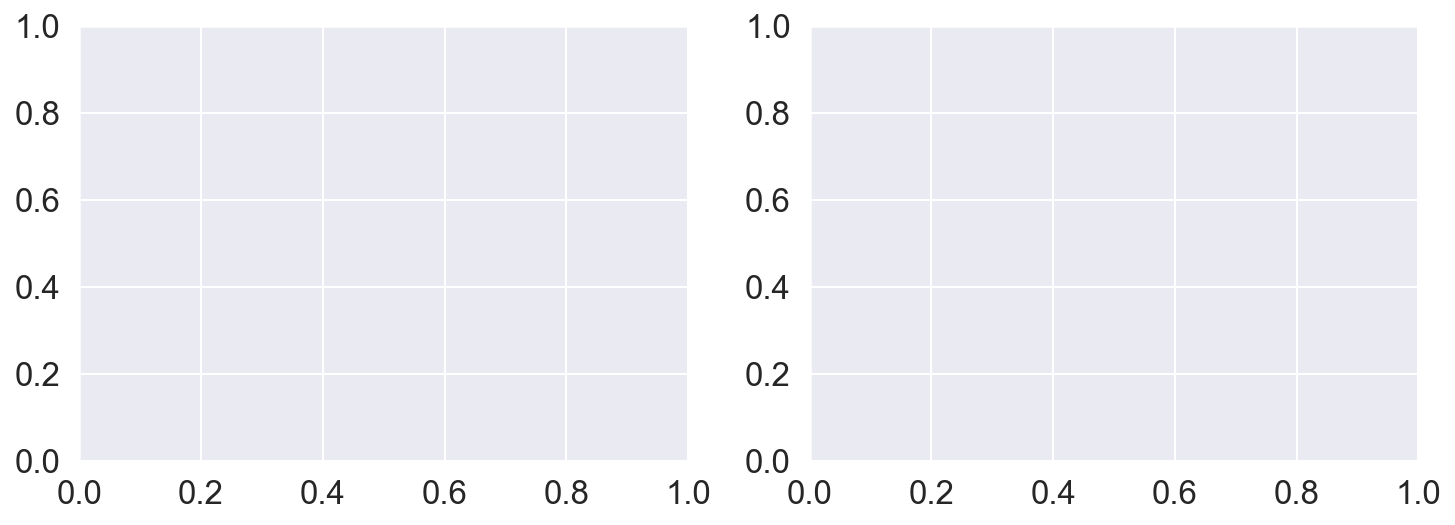

In [35]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].plot([mean_squared_error(data[i:], preds[i:len(data)])
            for i in range(10)])
ax[0].set_title('MSE')
ax[1].plot([r2_score(data[i:], preds[i:len(data)]) for i in range(10)])
ax[1].set_title('R2')
plt.show()


**Plot the residuals of the SARIMAX model.**

**Plot the ACF and PACF of the residuals.**

What should we be expecting from the ACF and PACF of our residuals if the model is good?

**Increase the order of the SARIMAX model.**

How do the results change?

<a id="forecast-using-the-sarimax-model"></a>
## Forecast using the SARIMAX model

Forecast 12 additional timepoints and plot them.